<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features # number of best features to select

    def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
        covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return X[:,self.best_feature_ids]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.93


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

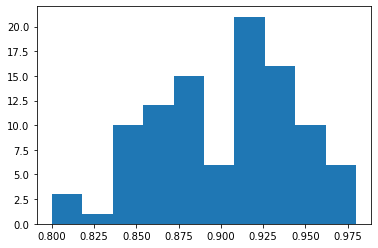

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

  # Feature selection:
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
    model = LinearSVC()

  # Estimatin accuracy using cross-validation:
    return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

The problem of the aforementioned task is that the data has not been splited properly. So, part for validation hides in training. That's why as the result, we get extremely high accuracy.
The possible solution for this issue could be using KFold in order to divide dataset into "training data-validation data-test data" (cross-validation). It will help to get rid of the observed defect.

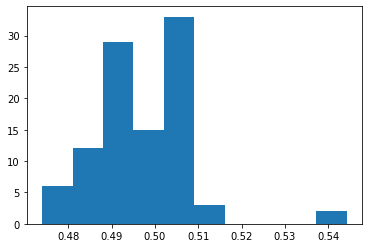

In [5]:
num_features_total = 1000
num_features_best = 100

N = 100
results = []
def experiment():
    # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)
    kf = KFold(n_splits=7, shuffle=True)
    for i_train, i_test in kf.split(X):
        X_train, X_test = X[i_train], X[i_test]
        y_train, y_test = y[i_train], y[i_test]
        # Feature selection:
        features = FeatureSelector(num_features_best)
        X_train_best = features.fit_transform(X_train, y_train)
        X_test_best = features.transform(X_test)
        # Simple classification model
        model = LinearSVC()
        # Fitting and cross-validation
        model.fit(X_train_best, y_train)
        results.append(sum(model.predict(X_test_best) == y_test) / len(y_test))
    return np.array(results).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [9]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either es

In [7]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

dataset = pd.read_csv(r"C:\Users\danys\Documents\MLDM-2022-main\01-intro\train.csv", index_col='PassengerId')
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
def feature_selection_and_preprocessing(dataset):
    features = dataset[["Fare", "Parch", "SibSp", "Pclass", "Sex"]].copy()
    features["Sex"].replace(['male', 'female'], [0,1], inplace=True)
    features["Fare"] /= features["Fare"].mean()
    features["Fare"] *= 1
    return features

grid_params = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 10, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsClassifier(),
                 grid_params,
                 verbose=1,
                 cv=5,
                 n_jobs=-1)

data_train = dataset.iloc[:-100]
data_test = dataset.iloc[-100:]

gs_results = gs.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

print('The best parameters are:', gs_results.best_params_)

test_predictions = gs.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)

print("Enhanced test accuracy: {}, comparing to 0.84".format(accuracy_score(
    data_test['Survived'],
    test_predictions)
    ))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
The best parameters are: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Enhanced test accuracy: 0.86, comparing to 0.84
